# Forest Plot

> Explanation of how to use forest_plot for contrast objects e.g delta-delta and mini-meta.

- order: 7

In DABEST version xx.xx.xx, we introduce a new function to plot separately calculated effect sizes in the same axes to allow direct visual comparisons. Currently you can make a forest plot for delta-delta and mini-meta effect sizes. 

# Forest plot of delta-delta effects

First please revisit the notebook '[Delta-delta Tutorial](05-delta_delta.html)' for how to generate a delta-delta effect size. We will generate three of them plot them into the same axes. Here we test the efficacy of 3 drugs named ``Drug1``, ``Drug2`` , and ``Drug3`` on a disease-causing mutation ```M``` based on disease metric ```Tumor Size```.  We want to know how the three drugs fare in ameliorating the phenotype metric ```Tumor Size```. 

|       | Wildtype | Mutant   |
|-------|---------|----------|
| Drug1  | X<sub>D<sub>1, W</sub> | X<sub>D<sub>1, M</sub> |
| Placebo | X<sub>P<sub>1, W</sub> | X<sub>P<sub>1, M</sub> |

|       | Wildtype | Mutant   |
|-------|---------|----------|
| Drug2  | X<sub>D<sub>2, W</sub> | X<sub>D<sub>2, M</sub> |
| Placebo | X<sub>P<sub>2, W</sub> | X<sub>P<sub>2, M</sub> |

|       | Wildtype | Mutant   |
|-------|---------|----------|
| Drug3  | X<sub>D<sub>3, W</sub> | X<sub>D<sub>3, M</sub> |
| Placebo | X<sub>P<sub>3, W</sub> | X<sub>P<sub>3, M</sub> |

In each scenario, there are two ``Treatment`` conditions, ``Placebo`` (control group) and ``Drug`` (test group). There are two ``Genotype``\'s: ``W`` (wild type population) and ``M`` (mutant population). Additionally, each experiment was conducted twice (``Rep1`` and ``Rep2``). We will perform several analyses to visualise these differences in a simulated dataset. We will simulate three separte datasets below. 

## Load libraries

In [ ]:
import numpy as np
import pandas as pd
import dabest
from dabest.forest_plot import forest_plot
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
# %matplotlib inline
import seaborn as sns
import dabest 
print("We're using DABEST v{}".format(dabest.__version__))

We're using DABEST v2024.03.29


## Simulate datasets for the delta-delta contrast objects

In [ ]:

from scipy.stats import norm

def create_delta_dataset(N=20, 
                        seed=9999, 
                        second_quarter_adjustment=3, 
                        third_quarter_adjustment=-0.1):
    np.random.seed(seed)  # Set the seed for reproducibility

    # Create samples
    y = norm.rvs(loc=3, scale=0.4, size=N*4)
    y[N:2*N] += second_quarter_adjustment
    y[2*N:3*N] += third_quarter_adjustment

    # Treatment, Rep, Genotype, and ID columns
    treatment = np.repeat(['Placebo', 'Drug'], N*2).tolist()
    rep = ['Rep1', 'Rep2'] * (N*2)
    genotype = np.repeat(['W', 'M', 'W', 'M'], N).tolist()
    id_col = list(range(0, N*2)) * 2

    # Combine all columns into a DataFrame
    df = pd.DataFrame({
        'ID': id_col,
        'Rep': rep,
        'Genotype': genotype,
        'Treatment': treatment,
        'Tumor Size': y
    })

    return df

# Generate the first dataset with a different seed and adjustments
df_delta2_drug1 = create_delta_dataset(seed=9999, second_quarter_adjustment=1, third_quarter_adjustment=-0.5)

# Generate the second dataset with a different seed and adjustments
df_delta2_drug2 = create_delta_dataset(seed=9999, second_quarter_adjustment=0.1, third_quarter_adjustment=-1)

# Generate the third dataset with the same seed as the first but different adjustments
df_delta2_drug3 = create_delta_dataset(seed=9999, second_quarter_adjustment=3, third_quarter_adjustment=-0.1)

## Creating contrast objects required for delta-delta forest_plot

In [ ]:
unpaired_delta_01 = dabest.load(data = df_delta2_drug1, 
                                x = ["Genotype", "Genotype"], 
                                y = "Tumor Size", delta2 = True, 
                                experiment = "Treatment")
unpaired_delta_02 = dabest.load(data = df_delta2_drug2, 
                                x = ["Genotype", "Genotype"], 
                                y = "Tumor Size", delta2 = True, 
                                experiment = "Treatment")
unpaired_delta_03 = dabest.load(data = df_delta2_drug3, 
                                x = ["Genotype", "Genotype"], 
                                y = "Tumor Size", 
                                delta2 = True, 
                                experiment = "Treatment")
contrasts = [unpaired_delta_01, unpaired_delta_02, unpaired_delta_03]

## Visualize the delta-delta plots for each datasets 

To create a delta-delta plot, you simply need to set ``delta2=True`` in the 
``dabest.load()`` function and ``mean_diff.plot()``

In this case,``x`` needs to be declared as a list consisting of 2 elements, unlike most cases where it is a single element. 
The first element in ``x`` will represent the variable plotted along the horizontal axis, and the second one will determine the 
color of dots for scattered plots or the color of lines for slope graphs. We use the ``experiment`` input to specify the grouping of the data.

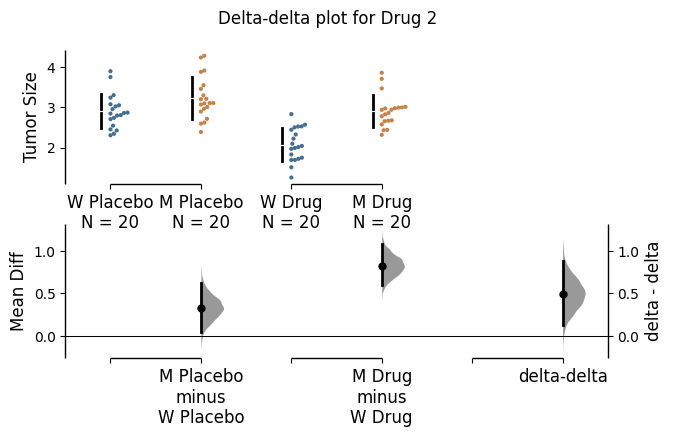

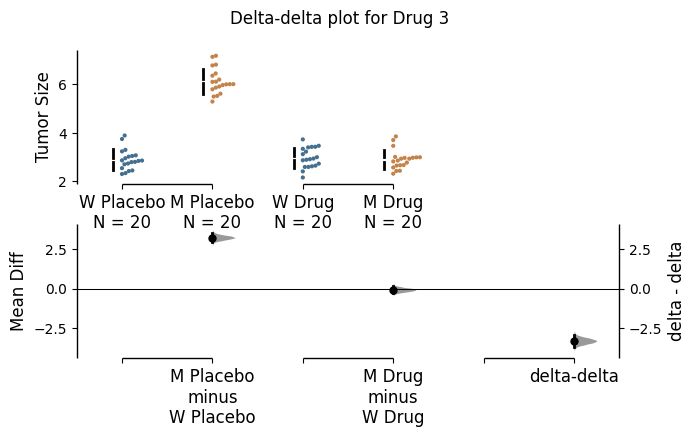

In [ ]:

f1 = unpaired_delta_01.mean_diff.plot(
    contrast_label='Mean Diff',
    fig_size = (7, 4),
    raw_marker_size = 1,
    es_marker_size = 5,
    color_col='Genotype'
);
f1.suptitle('Delta-delta plot for Drug 1');


f2 = unpaired_delta_02.mean_diff.plot(                  
            contrast_label='Mean Diff',
            fig_size = (7, 4),
            raw_marker_size = 1,
            es_marker_size = 5,
            color_col='Genotype'
);
f2.suptitle('Delta-delta plot for Drug 2');


f3 = unpaired_delta_03.mean_diff.plot(                  
                    contrast_label='Mean Diff',
                    fig_size = (7, 4),
                    raw_marker_size = 1,
                    es_marker_size = 5,
                    color_col='Genotype'
);
f3.suptitle('Delta-delta plot for Drug 3');


## Plot all the delta-delta plots into a forest plot for comparisons of different ``Drug`` effects

Key Parameters:

- ``contrasts``: A list of contrast objects 

- ``contrast_type``: Select between ``"delta2"`` (for delta-delta) or ``"mini_meta"`` for mini-meta 

- ``contrast_labels``: A list of labels for the contrast objects. E.g., ``['Drug1', 'Drug2', 'Drug3']``

- ``effect_size``: Select the effect size metric from ``"mean_diff", "median_diff", "cliffs_delta", "cohens_d", "hedges_g", or "delta_g"``. The default is ``"mean_diff"``

- ``ylabel``: The axis label of dependent variable (Y-axis for vertical layout, X-axis for horizontal layout). The default is ``"value"``

- ``title``: The plot title. The default is ``"ΔΔ Forest"``

- ``ax``: Specify a matplotlib axes to put the plot into existing figures 

- ``horizontal``: A boolean input (``True``/ ``False``) to adjust the plot orientation. The default is vertical orientation (``False``) 

- ``custom_palette``: A list or dictionary of colors, one for each contrast object. E.g., ``['gray', 'blue', 'green']`` or ``{'Drug1':'gray', 'Drug2':'blue', 'Drug3':'green'}``

- Additional kwargs are supported such as ``violin_kwargs``, ``fontsize``, ``marker_size``, ``ci_line_width``, ``rotation_for_xlabels``, ``alpha_violin_plot``, ``remove_spines``, ``desat_violin``, and ``additional_plotting_kwargs``


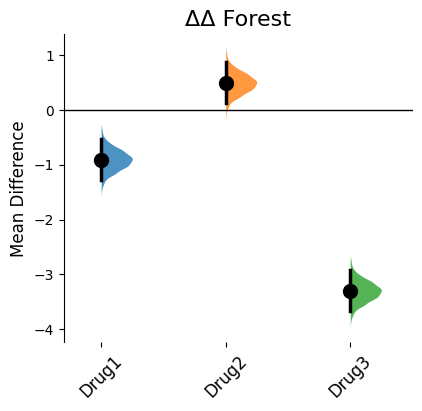

In [ ]:
f_forest_delta2 = forest_plot(contrasts, 
                               contrast_labels =['Drug1', 'Drug2', 'Drug3']);

# Forest plot of mini-meta effects:
Next we will generate a similar forest plot for mini-meta effect sizes. Please revisit the notebook '[Mini-meta Tutorial](04-mini_meta_delta.html)' on how to generate a mini-meta effect size. We will generate three mini-meta effect sizes for three separate mini-meta analyses:

## Simulate the datasets for three unpaired mini-meta effects

In [ ]:
def create_mini_meta_dataset(N=20, seed=9999, control_locs=[3, 3.5, 3.25], control_scales=[0.4, 0.75, 0.4], 
                             test_locs=[3.5, 2.5, 3], test_scales=[0.5, 0.6, 0.75]):
    np.random.seed(seed)  # Set the seed for reproducibility

    # Create samples for controls and tests
    controls_tests = []
    for loc, scale in zip(control_locs + test_locs, control_scales + test_scales):
        controls_tests.append(norm.rvs(loc=loc, scale=scale, size=N))

    # Add a `Gender` column for coloring the data
    gender = ['Female'] * (N // 2) + ['Male'] * (N // 2)

    # Add an `ID` column for paired data plotting
    id_col = list(range(1, N + 1))

    # Combine samples and gender into a DataFrame
    df_columns = {f'Control {i+1}': controls_tests[i] for i in range(len(control_locs))}
    df_columns.update({f'Test {i+1}': controls_tests[i + len(control_locs)] for i in range(len(test_locs))})
    df_columns['Gender'] = gender
    df_columns['ID'] = id_col

    df = pd.DataFrame(df_columns)

    return df

# Customizable dataset creation with different arguments
df_mini_meta01 = create_mini_meta_dataset(seed=9999, 
                                          control_locs=[3, 3.5, 3.25], 
                                          control_scales=[0.4, 0.75, 0.4], 
                                          test_locs=[3.5, 2.5, 3], 
                                          test_scales=[0.5, 0.6, 0.75])

df_mini_meta02 = create_mini_meta_dataset(seed=9999, 
                                          control_locs=[4, 2, 3.25], 
                                          control_scales=[0.3, 0.75, 0.45], 
                                          test_locs=[2, 1.5, 2.75], 
                                          test_scales=[0.5, 0.6, 0.4])

df_mini_meta03 = create_mini_meta_dataset(seed=9999, 
                                          control_locs=[6, 5.5, 4.25], 
                                          control_scales=[0.4, 0.75, 0.45], 
                                          test_locs=[4.5, 3.5, 3], 
                                          test_scales=[0.5, 0.6, 0.9])

## Creating contrast objects required for a mini-meta forest plot

In [ ]:
contrast_mini_meta01 = dabest.load(data = df_mini_meta01,
                                   idx=(("Control 1", "Test 1"), ("Control 2", "Test 2"), ("Control 3", "Test 3")), 
                                   mini_meta=True)
contrast_mini_meta02 = dabest.load(data = df_mini_meta02,
                                    idx=(("Control 1", "Test 1"), ("Control 2", "Test 2"), ("Control 3", "Test 3")), 
                                    mini_meta=True)
contrast_mini_meta03 = dabest.load(data = df_mini_meta03,
                                   idx=(("Control 1", "Test 1"), ("Control 2", "Test 2"), ("Control 3", "Test 3")),
                                    mini_meta=True)
contrasts_mini_meta = [contrast_mini_meta01, contrast_mini_meta02, contrast_mini_meta03]    
                              

## Generate the mini-meta forest plot

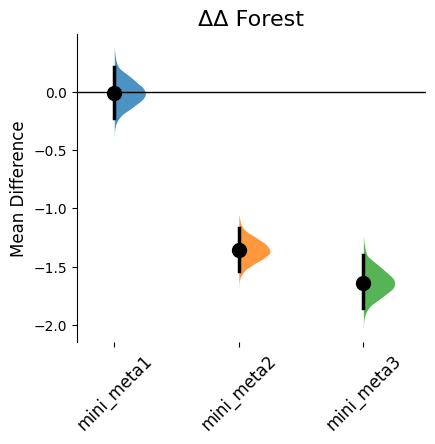

In [ ]:
f_forest_minimeta = forest_plot(contrasts_mini_meta, contrast_type='mini_meta', contrast_labels=['mini_meta1', 'mini_meta2', 'mini_meta3']);

# Control of aesthetics

### Changing layout 
Forest plot assumes a vertical layout by default, but you can change it to a horizontal layout by setting ```horizontal``` to be ```True```:

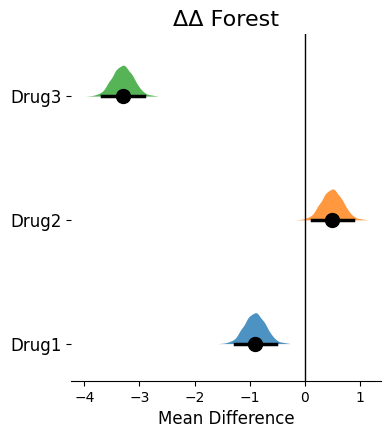

In [ ]:
f_forest_delta2_horizontal = forest_plot(contrasts, 
                                 contrast_labels =['Drug1', 'Drug2', 'Drug3'],
                                 horizontal=True);


### Using a custom palette 
You can color the half-violins with ```custom_palette```:

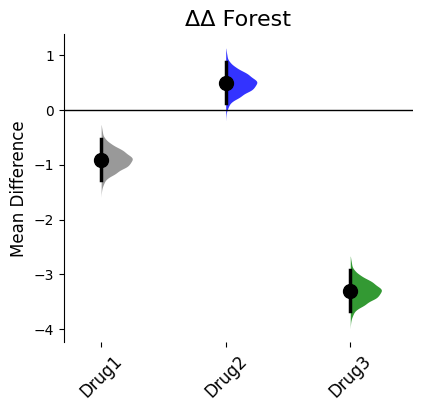

In [ ]:
f_forest_delta2_custom_palette= forest_plot(contrasts, 
                               contrast_labels = ['Drug1', 'Drug2', 'Drug3'], 
                               custom_palette = ['gray', 'blue', 'green'],  # or 
                                # custom_palette = {'Drug1':'gray', 'Drug2':'blue', 'Drug3':'green'}
                              );

### Plotting other effect sizes 
Forest plots can be drawn for effect sizes other than mean_difference, such as ```deltas' g```, by setting ```effect_size```:

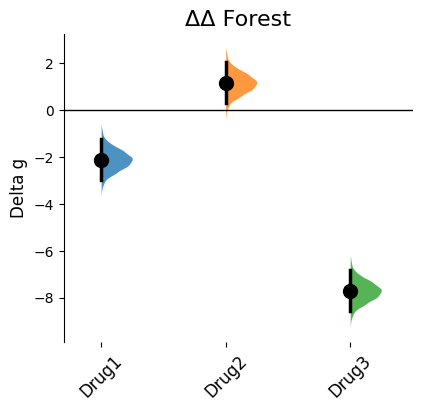

In [ ]:
f_forest_deltasg = forest_plot(contrasts, 
                                 contrast_labels =['Drug1', 'Drug2', 'Drug3'], effect_size='delta_g');

### Embedding forest plots into an existing Axes 

You can plot a forest plot into an existing Axes as a subplot by using the with the ``ax`` parameter. 

``Example 1``:

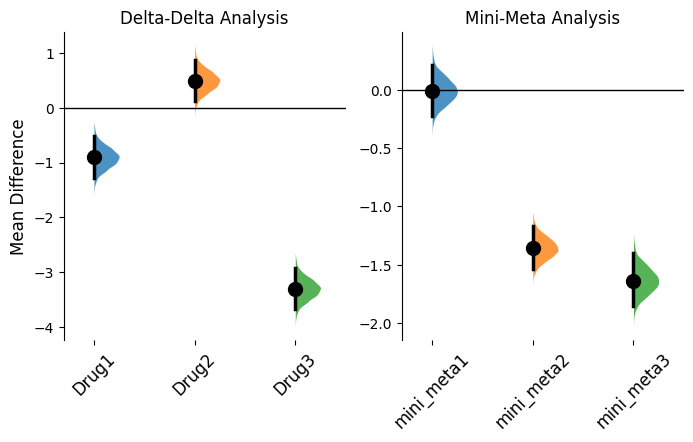

In [ ]:
f_two_forest_plots, axes  = plt.subplots(1, 2, figsize = [8, 4])
['Drug1', 'Drug2', 'Drug3']
forest_plot(contrasts, contrast_labels = ['Drug1', 'Drug2', 'Drug3'], ax = axes[0])

forest_plot(contrasts_mini_meta, contrast_type = "mini_meta", contrast_labels = ['mini_meta1', 'mini_meta2', 'mini_meta3'], ax = axes[1])

axes[0].set_title('Delta-Delta Analysis', fontsize = 12);
axes[1].set_ylabel('');
axes[1].set_title('Mini-Meta Analysis', fontsize = 12);


In [ ]:
f_forest_drug_profiles, axes  = plt.subplots(1, 2, figsize = [8, 4])
['Drug1', 'Drug2', 'Drug3']
forest_plot(contrasts, contrast_labels = ['Drug1', 'Drug2', 'Drug3'], ax = axes[0])
forest_plot(contrasts_mini_meta, contrast_type = "mini_meta", contrast_labels = ['mini_meta1', 'mini_meta2', 'mini_meta3'], ax = axes[1])
axes[0].set_title('Delta-Delta Analysis', fontsize = 20)
axes[1].set_ylabel('')
axes[1].set_title('Mini-Meta Analysis', fontsize = 20)


Text(0.5, 1.0, 'Mini-Meta Analysis')

``Example 2``:

In [ ]:
f_forest_drug_profiles, axes  = plt.subplots(2, 2, figsize=[15, 14])
contrast_labels1 = ['Drug1', 'Drug2', 'Drug3']
unpaired_delta_01.mean_diff.plot(                  
                    contrast_label='Mean Diff',
                    fig_size = (5, 5),
                    raw_marker_size = 1,
                    es_marker_size = 5,
                    color_col='Genotype',
                    ax = axes[0,0]
)

unpaired_delta_02.mean_diff.plot(                  
            contrast_label='',
            fig_size = (5, 5),
            raw_marker_size = 1,
            es_marker_size = 5,
            color_col='Genotype',
            ax = axes[0,1]
)


unpaired_delta_03.mean_diff.plot(                  
                    contrast_label='Mean Diff',
                    fig_size = (5, 5),
                    raw_marker_size = 1,
                    es_marker_size = 5,
                    color_col='Genotype',
                    ax = axes[1,0]
)
forest_plot(contrasts, contrast_labels = contrast_labels1 , ax = axes[1,1], )
axes[0,0].set_title('Drug1', fontsize = 12);
axes[0,0].set_ylabel('')
axes[0,1].set_ylabel('')
axes[0,1].set_title('Drug2', fontsize = 12);
axes[1,0].set_title('Drug3', fontsize = 12);
axes[0,1].set_ylabel('')
axes[1,1].set_title('Forest plot', fontsize = 12) ;
